`Data Preprocessing` || Model Training || Streamlit App

---
# Solar Up -- Solar Panel Object Detection and Segmentation

WBS Coding School || Data Science Bootcamp || Final Project

---

### Table of Contents
- [1. Load and Save Data](#load)
- [2. Separate Images with Solar Panels from Images w/o Panels](#separate)
- [3. Convert Masks to Segmentation Labels](#convert_masks)
- [4. Convert Segmentation Labels to Bounding Boxes](#convert_labels)
- [5. Train-Test Split](#split)
- [6. Zip and Export](#export)

#### Libraries

In [2]:
# Standard library imports
import os
import shutil
import json

# Third party imports
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision.io import read_image, ImageReadMode
from torchvision.utils import draw_segmentation_masks
from torchvision.ops import masks_to_boxes
import torchvision.transforms.functional as F
import ultralytics
from ultralytics import YOLO
import random

___
<a id="load"></a>
## 1.&nbsp; Load & Save Data

The dataset is a crowdsourced dataset of aerial images with annotated solar photovoltaic arrays and installation metadata. It contains over 28,000 images, 13,000 ground truth segmentation masks, and metadata for more than 8,000 installations. The dataset was created to address the challenges of distribution shift in solar photovoltaic array mapping pipelines.
The dataset was published in Nature in 2023 with the title [A crowdsourced dataset of aerial images with annotated solar photovoltaic arrays and installation metadata
](https://www.nature.com/articles/s41597-023-01951-4#Fig2)

Images: The dataset includes aerial images from two different sources: Google Earth Engine and the Institut national de l'information géographique et forestière (IGN). The images are in RGB format and have a resolution of 256x256 pixels.

Segmentation masks: The segmentation masks are generated from polygon annotations of the users. Each segmentation mask represents the boundary of a solar photovoltaic array.

Installation metadata: The metadata includes information about the location, size, and type of each solar photovoltaic array.

The dataset is available for download from the [Zenodo repository](https://zenodo.org/records/7358126).

In [2]:
# Define dataset name
dataset_name = "kasmi_solar"

# Define the directory to save the files in
save_dir = f"data/{dataset_name}"

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# URLs of the files to download
url1 = "https://zenodo.org/records/7358126/files/bdappv.zip?download=1"
url2 = "https://zenodo.org/records/7358126/files/data.zip?download=1"

In [ ]:
# Download the image files
os.system(f'wget -O {os.path.join(save_dir, "bdappv.zip")} {url1}')

In [ ]:
# Download the additional data files (metadata)
os.system(f'wget -O {os.path.join(save_dir, "data.zip")} {url2}')

In [ ]:
!unzip 'data/kasmi_solar/data.zip' -d data/kasmi_solar
!unzip 'data/kasmi_solar/bdappv.zip' -d data/kasmi_solar

In [6]:
# Remove zip files
!rm data/kasmi_solar/data.zip
!rm data/kasmi_solar/bdappv.zip

The dataset is composed of images, some of which feature solar panels and others do not. For those images that do contain solar panels, corresponding mask PNG files are provided. 

In [30]:
dataset_name = "kasmi_solar"

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [31]:
# Read in an image and its mask
IMAGE_DIRECTORY = f"data/{dataset_name}/bdappv/google"

img_path = os.path.join(IMAGE_DIRECTORY, "img/AAKEG5A92ACPSX.png")
mask_path = os.path.join(IMAGE_DIRECTORY, "mask/AAKEG5A92ACPSX.png")

img = read_image(img_path, mode=ImageReadMode.RGB)
mask = read_image(mask_path, mode=ImageReadMode.GRAY)

torch.Size([3, 400, 400])
torch.Size([1, 400, 400])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)


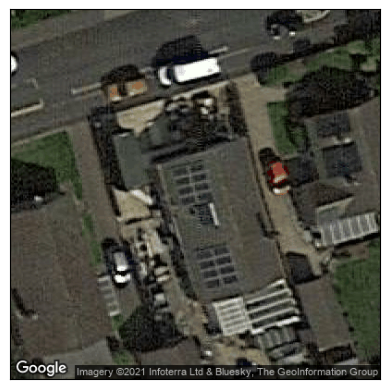

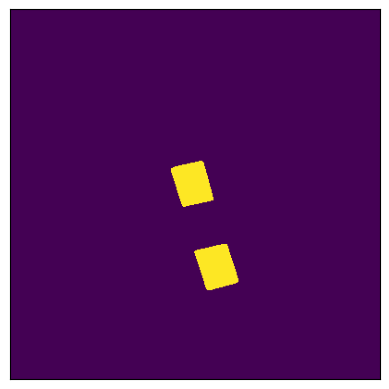

In [32]:
print(img.size())
print(mask.size())
print(mask)

show(img)
show(mask)

However, for images without solar panels, no such mask files exist.

In [33]:
# function to count files in directory because we will use that often to doublecheck
def count_files_in_directory(directory):
    return len(
        [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    )

In [34]:
# Print the number of files in the image and mask folder
num_img_files = count_files_in_directory(f"data/{dataset_name}/bdappv/google/img")
print(f"Number of files in img folder: {num_img_files}")
num_mask_files = count_files_in_directory   (f"data/{dataset_name}/bdappv/google/mask")
print(f"Number of files in mask folder: {num_mask_files}")

Number of files in img folder: 28807
Number of files in mask folder: 13303


___
<a id="separate"></a>
## 2.&nbsp; Separate Images with Solar Panels from Images w/o Panels

In [35]:
all_images = os.listdir("data/kasmi_solar/bdappv/google/img/")
images_with_masks = os.listdir("data/kasmi_solar/bdappv/google/mask/")
images_without_masks = [x for x in all_images if x not in images_with_masks]

len(images_without_masks + images_with_masks) == len(all_images)

True

In [36]:
source = f"data/{dataset_name}/bdappv/google/img/"
destination = f"data/{dataset_name}/bdappv/google/img_with_panels/"

try:
    os.makedirs(destination, exist_ok=False)
except OSError:
    pass

for i in images_with_masks:
    shutil.copy(source + i, destination)

count_files_in_directory(f"data/{dataset_name}/bdappv/google/img_with_panels/")

13303

___
<a id="convert_masks"></a>
## 3.&nbsp; Convert Masks to Segmentation Labels

To train a segmentation model, our **labels need to be the solar panel masks**.

The kasmi_solar/data/ folder contains a JSON file with information on the polygon masks around the solar panels. For every image with solar panels, all points of each polygon are recorded with x and y coordinates.

We'll create a function that retrieves the polygon data from the JSON file and stores it in separate TXT files for each image.

In [37]:
def convert_polygons_to_txt(json_file, output_dir):
    # This function converts polygons from a JSON file to a TXT file

    with open(json_file, "r") as f:  # Open the JSON file in read mode
        data = json.load(f)  # Load the JSON data into a Python object

    for surface_result in data:  # Loop through each surface result in the data
        id = surface_result["id"]  # Get the ID of the surface result
        polygons = surface_result["polygons"]  # Get the polygons of the surface result

        filename = f"{id}.txt"  # Create a filename using the ID
        filepath = os.path.join(
            output_dir, filename
        )  # Create the full path to the output file

        # Check if the directory exists, if not, create it
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        with open(filepath, "w") as f:  # Open the output file in write mode
            for polygon in polygons:  # Loop through each polygon
                f.write("0")  # Write a "0" at the start of each line
                for point in polygon[
                    "points"
                ]:  # Loop through each point in the polygon
                    f.write(
                        f" {point['x']} {point['y']}"
                    )  # Write the x and y coordinates of the point
                f.write(
                    "\n"
                )  # Write a newline character to indicate the end of the polygon

In [38]:
convert_polygons_to_txt(
    f"data/{dataset_name}/data/replication/campaign-google/polygon-analysis.json",
    f"data/{dataset_name}/bdappv/google/labels_segmentation/not_normalized",
)

In [39]:
count_files_in_directory(
    f"data/{dataset_name}/bdappv/google/labels_segmentation/not_normalized"
)

13303

The segmentation models in YOLOv8 necessitate the use of normalized polygon data. Therefore, we will create an additional function to procure this normalized information.

In [40]:
def convert_polygons_normalized_to_txt(json_file, output_dir):
    # This function converts polygons from a JSON file to a TXT file

    with open(json_file, "r") as f:  # Open the JSON file in read mode
        data = json.load(f)  # Load the JSON data into a Python object

    for surface_result in data:  # Loop through each surface result in the data
        id = surface_result["id"]  # Get the ID of the surface result
        polygons = surface_result["polygons"]  # Get the polygons of the surface result

        filename = f"{id}.txt"  # Create a filename using the ID
        filepath = os.path.join(
            output_dir, filename
        )  # Create the full path to the output file

        # Check if the directory exists, if not, create it
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        with open(filepath, "w") as f:  # Open the output file in write mode
            for polygon in polygons:  # Loop through each polygon
                f.write("0")  # Write a "0" at the start of each line
                for point in polygon[
                    "points"
                ]:  # Loop through each point in the polygon
                    # Normalize the x and y coordinates and write them to the file
                    x = point["x"] / 400  # 400 because the images are 400x400px
                    y = point["y"] / 400  # 400 because the images are 400x400px
                    f.write(f" {x} {y}")
                f.write(
                    "\n"
                )  # Write a newline character to indicate the end of the polygon

In [41]:
convert_polygons_normalized_to_txt(
    f"data/{dataset_name}/data/replication/campaign-google/polygon-analysis.json",
    f"data/{dataset_name}/bdappv/google/labels_segmentation/normalized",
)

In [42]:
count_files_in_directory(
    f"data/{dataset_name}/bdappv/google/labels_segmentation/normalized"
)

13303

___
<a id="convert_labels"></a>
## 4.&nbsp; Convert Segmentation Labels to Bounding Boxes <br> (i.e. Detection Labels)

To train an object detection model, we need **labels in the form of bounding boxes** for each solar panel. We can generate bounding boxes from the polygon segmentation labels. Note that the labels need to be in the right format for YOLO. They will look something like this:

0 0.5175 0.665 0.070 0.08 <br>
0 0.4937 0.505 0.082 0.11 <br>
0 0.9537 0.128 0.087 0.18 <br>

These are lables for one image that contains three solar panels. Each line represents one solar panel. <br> The five numbers per line represent:

*class - center_x - center_y - width - height*

In [43]:
def convert_segmentation_labels_to_bounding_boxes(filename):
    bounding_boxes_labels = []
    with open(filename, "r") as file:
        for line in file:
            # Split the line into the coordinates
            coordinates = line.split()

            # Extract the class label (first element)
            class_label = int(coordinates[0])

            # Convert the rest of the coordinates to a list of pairs
            points = []
            for i in range(1, len(coordinates), 2):
                points.append((float(coordinates[i]), float(coordinates[i + 1])))

            # Convert the polygon to bounding box
            x_min, _ = min(points, key=lambda point: point[0])
            _, y_min = min(points, key=lambda point: point[1])
            x_max, _ = max(points, key=lambda point: point[0])
            _, y_max = max(points, key=lambda point: point[1])

            # Calculate bounding box coordinates in YOLOv8 format (center coordinates and width/height)
            center_x = (x_min + x_max) / 2
            center_y = (y_min + y_max) / 2
            width = x_max - x_min
            height = y_max - y_min
            bbox_xywh = [center_x, center_y, width, height]

            # Append bounding box label
            bounding_boxes_labels.append((class_label, bbox_xywh))

    return bounding_boxes_labels

We now require a function that converts all segmentation labels into detection labels and stores them in a separate directory.

In [44]:
def process_files(input_path, output_path):
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)

    # Loop over all files in the input directory
    for filename in os.listdir(input_path):
        # Full path to the current input file
        input_file = os.path.join(input_path, filename)

        # Process the file
        bounding_boxes = convert_segmentation_labels_to_bounding_boxes(input_file)

        # Full path to the output file
        output_file = os.path.join(output_path, filename)

        # Save the bounding boxes to the output file
        with open(output_file, "w") as file:
            for class_label, bbox_xywh in bounding_boxes:
                # Convert the bounding box to a string
                bbox_str = " ".join(map(str, bbox_xywh))

                # Write the class label and bounding box to the file
                file.write(f"{class_label} {bbox_str}\n")

In [45]:
process_files(
    f"data/{dataset_name}/bdappv/google/labels_segmentation/normalized",
    f"data/{dataset_name}/bdappv/google/labels_detection",
)

In [46]:
count_files_in_directory(f"data/{dataset_name}/bdappv/google/labels_detection")

13303

We now have all the images that contain solar panels and we've created labels for both object segmentation (normalized polygon x,y values) and detection (bounding boxes in YOLO format).

___
<a id="split"></a>
## 5.&nbsp; Train-Test Split

#### Create Directories

Before we do the train-test split, we'll create separate directories for the detection and segmentation approaches. We'll create the directories `kasmi_solar_detection` and `kasmi_solar_segmentation`, which will contain `test`, `train` and `val` directories, that will in turn include the sub-directories `images` and `labels`.

The configuration files (.yaml) will inform YOLOv8 about exactly this directory structure. That way, YOLO can automatically find the according data and labels.

In [47]:
def make_directory(model_approach: str):
    """
    Create directories and sub-directories for the preprocessed images and labels.
    """
    directory_name = f"kasmi_solar_{model_approach}"
    for dataset_type in ["train", "test", "val"]:
        os.makedirs(os.path.join("datasets", directory_name, dataset_type), exist_ok=True)

        for file_type in ["images", "labels"]:
            os.makedirs(os.path.join("datasets", directory_name, dataset_type, file_type), exist_ok=True)

In [48]:
make_directory(model_approach="detection")
make_directory(model_approach="segmentation")

#### Perform Train-Test Split

We first perform the splitting on a list of image IDs, after which we copy the train/test/val images to their respective repositories.

In [49]:
# Define the path to the images that contain solar panels.
source_path_imgs = f"data/{dataset_name}/bdappv/google/img_with_panels/"
# Create a list of image IDs for subsequent splitting.
imgs_list = os.listdir(source_path_imgs)
img_ids = [str.rstrip(i, ".png") for i in imgs_list]

Next, we perform a double split, which results in the following distribution:

train:        70 %<br>
test:         15 %<br>
validation:   15 %

In [50]:
# Split up image IDs.
train_ids, test_and_val_ids = train_test_split(
    img_ids, test_size=0.3, random_state=42
)  # train: 0.7, test+val: 0.3
test_ids, val_ids = train_test_split(
    test_and_val_ids, test_size=0.5, random_state=42
)  # test: 0.15, val: 0.15

print(len(train_ids), len(test_ids), len(val_ids))
print(len(train_ids) + len(test_ids) + len(val_ids))

# Define a dictionary with keys 'train', 'test', 'val' and values as lists of ids.
# These ids determine which files belong to the train, test, and validation sets, respectively.
ids_dict = {"train": train_ids, "test": test_ids, "val": val_ids}

9312 1995 1996
13303


##### Copy Detection Images and Labels

The final step is copying the images and their labels to the respective directories, i.e. training images and labels (identified by `train_ids`) to the `/train` directory, et cetera.

In [51]:
def copy_detection_files(origin_path, destination_path, ids_dict):
    """
    Copy images and labels for the object detection model to YOLO-organized directories.

    Parameters:
    origin_path (str): The path to the original files.
    destination_path (str): The path to the destination directories.
    ids_dict (dict): A dictionary with keys 'train', 'test', 'val' and values as lists of ids.
    """

    # For each dataset type (train, test split) ...
    for dataset_type in ids_dict:

        # ... and every ID therein ...
        for id in ids_dict[dataset_type]:
            
            # ... copy labels and images from origin_path/folder/ to destination_path/destination_folder/.
            for origin_folder, destination_folder, file_type in zip(
                ["img_with_panels", "labels_detection"], 
                ["images", "labels"],
                ["png", "txt"]
                ):
            
                try:
                    shutil.copy(
                        os.path.join(origin_path, origin_folder, f"{id}.{file_type}"),
                        os.path.join(destination_path, dataset_type, destination_folder)
                        )
                # If source and destination are same
                except shutil.SameFileError:
                    print("Source and destination represents the same file.")
                # If file does not exist:
                except OSError as e:
                    print(f"File {id}.png does not exist in {origin_path}/img_with_panels.")
                # Else:
                except:
                    print("Error occurred while copying file.")

In [52]:
copy_detection_files(
    origin_path=f"data/{dataset_name}/bdappv/google/",
    destination_path="datasets/kasmi_solar_detection/",
    ids_dict=ids_dict
)

##### Copy Segmentation Images and Labels

This function is the same as the one above, just slightly adjusted to the segmentation origin and destianation paths.

In [53]:
def copy_segmentation_files(origin_path, destination_path, ids_dict):
    """
    Copy images and labels for the object segmentation model to YOLO-organized directories.

    Parameters:
    origin_path (str): The path to the original files.
    destination_path (str): The path to the destination directories.
    ids_dict (dict): A dictionary with keys 'train', 'test', 'val' and values as lists of ids.
    """

    # For each dataset type (train, test split) ...
    for dataset_type in ids_dict:

        # ... and every ID therein ...
        for id in ids_dict[dataset_type]:
            
            # ... copy labels and images from origin_path/folder/ to destination_path/destination_folder/.
            for origin_folder, destination_folder, file_type in zip(
                ["img_with_panels", "labels_segmentation/normalized"], 
                ["images", "labels"],
                ["png", "txt"]
                ):
            
                try:
                    shutil.copy(
                        os.path.join(origin_path, origin_folder, f"{id}.{file_type}"),
                        os.path.join(destination_path, dataset_type, destination_folder)
                        )
                # If source and destination are same
                except shutil.SameFileError:
                    print("Source and destination represents the same file.")
                # If file does not exist:
                except OSError as e:
                    print(f"File {id}.png does not exist in {origin_path}/img_with_panels.")
                # Else:
                except:
                    print("Error occurred while copying file.")

In [54]:
copy_segmentation_files(
    origin_path=f"data/{dataset_name}/bdappv/google/",
    destination_path="datasets/kasmi_solar_segmentation/",
    ids_dict=ids_dict
)

___
<a id="export"></a>
## 6.&nbsp; Zip and Export

Here we compress the prepared datasets so that we can use it on a more powerful Google Colab machine for model training. 

We upload the zip file with the training data (`kasmi_solar_detection.zip`/`kasmi_solar_segmentation.zip`) to a Google Drive and subsequently mount it on Colab. We do the same with the corresponding configuration file (`kasmi_solar_detection.yaml`/`kasmi_solar_segmentation.yaml`). 

In [59]:
shutil.make_archive("datasets/kasmi_solar_detection", format="zip", 
                    root_dir='datasets/kasmi_solar_detection')

'/home/vugz/x/solar/solar_panel_object_detection/datasets/kasmi_solar_detection.zip'

In [60]:
for model_approach in ["detection", "segmentation"]:
    folder_to_compress = f"{dataset_name}_{model_approach}"
    shutil.make_archive(f"datasets/{folder_to_compress}", format="zip",
                        root_dir=f"datasets/{folder_to_compress}")